In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import patsy

from sklearn.linear_model import LinearRegression

from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 1000)

from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

In [2]:
class ResidTransform(BaseEstimator, TransformerMixin):
    """"""
    def __init__(self, confound):
        self.confound = confound
        
    def fit(self, x, y = None):
        self.lm = LinearRegression().fit(self.confound,x)
        return self
    
    def transform(self, x, confound=None):
        if confound is None:
            confound = self.confound
        return (x - (self.lm.coef_[0]*(confound.squeeze() - confound.mean())))

def residualize(confound, X):
    rt = ResidTransform(confound.reshape((-1,1)))
    rt_fitted = rt.fit(X)
    return rt.transform(X)

In [3]:
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri

In [4]:
def run_combat(feats, meta, model="~interview_age + gender", par_prior=False, par_fallback=True):

    import rpy2.robjects as robjects
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import importr


    rpy2.robjects.numpy2ri.activate()
    importr('sva')
    importr('BiocParallel')
    combat = robjects.r('ComBat')
    model_matrix = patsy.dmatrix(model, meta)
    fmat = np.array(feats).T
    rbatch = robjects.IntVector(pd.Categorical(meta.MRI_serial_number).codes)
    combat_result = combat(dat = fmat, batch = rbatch, mod = model_matrix, par_prior=par_prior)
    combat_result = np.array(combat_result)
    if par_fallback & ~par_prior & (pd.isnull(combat_result).sum() > 0):
        print("Nonparametric prior failed, falling back to parametric.", flush=True)
        combat_result = combat(dat = fmat, batch = rbatch, mod = model_matrix, par_prior=True)
        combat_result = np.array(combat_result)
        
    if pd.isnull(combat_result).sum() > 0:
        raise ValueError("ComBat has returned nans")
        
    return combat_result

In [5]:
dat = pd.read_excel('../data/alldatabadQCremoved.xlsx')
dat = dat.loc[dat['sex'].notnull(), :]
dat = dat.rename(columns={'sex':'gender'})
dat.head()

,subjectkey,collection_id.x,abcd_smrip101_id,dataset_id.x,src_subject_id.x,interview_date.x,interview_age.x,sex.x,eventname.x,smri_visitid,smri_thick_cdk_banksstslh,smri_thick_cdk_cdacatelh,smri_thick_cdk_cdmdfrlh,smri_thick_cdk_cuneuslh,smri_thick_cdk_ehinallh,smri_thick_cdk_fusiformlh,smri_thick_cdk_ifpllh,smri_thick_cdk_iftmlh,smri_thick_cdk_ihcatelh,smri_thick_cdk_locclh,smri_thick_cdk_lobfrlh,smri_thick_cdk_linguallh,smri_thick_cdk_mobfrlh,smri_thick_cdk_mdtmlh,smri_thick_cdk_parahpallh,smri_thick_cdk_paracnlh,smri_thick_cdk_parsopclh,smri_thick_cdk_parsobislh,smri_thick_cdk_parstgrislh,smri_thick_cdk_pericclh,smri_thick_cdk_postcnlh,smri_thick_cdk_ptcatelh,smri_thick_cdk_precnlh,smri_thick_cdk_pclh,smri_thick_cdk_rracatelh,smri_thick_cdk_rrmdfrlh,smri_thick_cdk_sufrlh,smri_thick_cdk_supllh,smri_thick_cdk_sutmlh,smri_thick_cdk_smlh,smri_thick_cdk_frpolelh,smri_thick_cdk_tmpolelh,smri_thick_cdk_trvtmlh,smri_thick_cdk_insulalh,smri_thick_cdk_banksstsrh,smri_thick_cdk_cdacaterh,smri_thick_cdk_cdmdfrrh,smri_thick_cdk_cuneusrh,smri_thick_cdk_ehinalrh,smri_thick_cdk_fusiformrh,smri_thick_cdk_ifplrh,smri_thick_cdk_iftmrh,smri_thick_cdk_ihcaterh,smri_thick_cdk_loccrh,smri_thick_cdk_lobfrrh,smri_thick_cdk_lingualrh,smri_thick_cdk_mobfrrh,smri_thick_cdk_mdtmrh,smri_thick_cdk_parahpalrh,smri_thick_cdk_paracnrh,smri_thick_cdk_parsopcrh,smri_thick_cdk_parsobisrh,smri_thick_cdk_parstgrisrh,smri_thick_cdk_periccrh,smri_thick_cdk_postcnrh,smri_thick_cdk_ptcaterh,smri_thick_cdk_precnrh,smri_thick_cdk_pcrh,smri_thick_cdk_rracaterh,smri_thick_cdk_rrmdfrrh,smri_thick_cdk_sufrrh,smri_thick_cdk_suplrh,smri_thick_cdk_sutmrh,smri_thick_cdk_smrh,smri_thick_cdk_frpolerh,smri_thick_cdk_tmpolerh,smri_thick_cdk_trvtmrh,smri_thick_cdk_insularh,smri_thick_cf2_frlh,smri_thick_cf2_ptlh,smri_thick_cf4_frlh,smri_thick_cf4_occlh,smri_thick_cf4_tmlh,smri_thick_cf4_pllh,smri_thick_cf12_cnlh,smri_thick_cf12_occlh,smri_thick_cf12_ptoltmlh,smri_thick_cf12_supllh,smri_thick_cf12_obfrlh,smri_thick_cf12_sutmlh,smri_thick_cf12_ifpllh,smri_thick_cf12_dmfrlh,smri_thick_cf12_aomtmlh,smri_thick_cf12_pclh,smri_thick_cf12_dlprefrlh,smri_thick_cf12_parsopclh,smri_thick_cf2_frrh,smri_thick_cf2_ptrh,smri_thick_cf4_frrh,smri_thick_cf4_occrh,smri_thick_cf4_tmrh,smri_thick_cf4_plrh,smri_thick_cf12_cnrh,smri_thick_cf12_occrh,smri_thick_cf12_ptoltmrh,smri_thick_cf12_suplrh,smri_thick_cf12_obfrrh,smri_thick_cf12_sutmrh,smri_thick_cf12_ifplrh,smri_thick_cf12_dmfrrh,smri_thick_cf12_aomtmrh,smri_thick_cf12_pcrh,smri_thick_cf12_dlprefrrh,smri_thick_cf12_parsopcrh,smri_thick_cdk_meanlh,smri_thick_cdk_meanrh,smri_thick_cdk_mean,smri_sulc_cdk_banksstslh,smri_sulc_cdk_cdacatelh,smri_sulc_cdk_cdmdfrlh,smri_sulc_cdk_cuneuslh,smri_sulc_cdk_ehinallh,smri_sulc_cdk_fusiformlh,smri_sulc_cdk_ifpllh,smri_sulc_cdk_iftmlh,smri_sulc_cdk_ihcatelh,smri_sulc_cdk_locclh,smri_sulc_cdk_lobfrlh,smri_sulc_cdk_linguallh,smri_sulc_cdk_mobfrlh,smri_sulc_cdk_mdtmlh,smri_sulc_cdk_parahpallh,smri_sulc_cdk_paracnlh,smri_sulc_cdk_parsopclh,smri_sulc_cdk_parsobislh,smri_sulc_cdk_parstgrislh,smri_sulc_cdk_pericclh,smri_sulc_cdk_postcnlh,smri_sulc_cdk_ptcatelh,smri_sulc_cdk_precnlh,smri_sulc_cdk_pclh,smri_sulc_cdk_rracatelh,smri_sulc_cdk_rrmdfrlh,smri_sulc_cdk_sufrlh,smri_sulc_cdk_supllh,smri_sulc_cdk_sutmlh,smri_sulc_cdk_smlh,smri_sulc_cdk_frpolelh,smri_sulc_cdk_tmpolelh,smri_sulc_cdk_trvtmlh,smri_sulc_cdk_insulalh,smri_sulc_cdk_banksstsrh,smri_sulc_cdk_cdacaterh,smri_sulc_cdk_cdmdfrrh,smri_sulc_cdk_cuneusrh,smri_sulc_cdk_ehinalrh,smri_sulc_cdk_fusiformrh,smri_sulc_cdk_ifplrh,smri_sulc_cdk_iftmrh,smri_sulc_cdk_ihcaterh,smri_sulc_cdk_loccrh,smri_sulc_cdk_lobfrrh,smri_sulc_cdk_lingualrh,smri_sulc_cdk_mobfrrh,smri_sulc_cdk_mdtmrh,smri_sulc_cdk_parahpalrh,smri_sulc_cdk_paracnrh,smri_sulc_cdk_parsopcrh,smri_sulc_cdk_parsobisrh,smri_sulc_cdk_parstgrisrh,smri_sulc_cdk_periccrh,smri_sulc_cdk_postcnrh,smri_sulc_cdk_ptcaterh,smri_sulc_cdk_precnrh,smri_sulc_cdk_pcrh,smri_sulc_cdk_rracaterh,smri_sulc_cdk_rrmdfrrh,smri_sulc_cdk_su

In [6]:
cols = [{'prefix': 'smri_vol_scs',
         'cor_col': 'smri_vol_scs_intracranialv',
         'col_range': 'all',
         'exclude': ['wholeb', 'latventricles', 'allventricles', 'intracranialv', 'suprateialv', 'subcorticalgv', 'csf', 'lesion', 'wmhint', 'cbwmatter'],
         'name': 'subcortical_regional_volume',
         'ncol': 32,
         'labelfile': 'ggSegAsegLabel.xlsx'},
        {'prefix':'smri_vol_cdk',
         'cor_col': 'smri_vol_cdk_total',
         'col_range': 'all',
         'exclude': ['total'],
         'name': 'Desikan_cortical_volume',
         'ncol':68, 
         'labelfile': 'ggSegDktLabel.xlsx'},
        {'prefix':'mrisdp',
         'cor_col': 'mrisdp_604',
         'col_range': (454,602),
         'exclude': [],
         'name': 'Destrieux_cortical_volume',
         'ncol':148,
         'labelfile':'ggSegDestLabel.xlsx'},
        
        {'prefix':'smri_thick_cdk',
         'cor_col': 'smri_thick_cdk_mean',
         'col_range': 'all',
         'exclude': ['mean'],
         'name': 'Desikan_cortical_thickness',
         'ncol':68, 
         'labelfile': 'ggSegDktLabel.xlsx'},
        {'prefix':'mrisdp',
         'cor_col': 'mrisdp_151',
         'col_range': (1,149),
         'exclude': [],
         'name': 'Destrieux_cortical_thickness',
         'ncol':148,
         'labelfile': 'ggSegDestLabel.xlsx'},
        
        {'prefix':'smri_area_cdk',
         'cor_col': 'smri_area_cdk_total',
         'col_range': 'all',
         'exclude': ['total'],
         'name': 'Desikan_cortical_area',
         'ncol':68,
         'labelfile': 'ggSegDktLabel.xlsx'},
        {'prefix':'mrisdp',
         'cor_col': 'mrisdp_453',
         'col_range': (303,451),
         'exclude': [],
         'name': 'Destrieux_cortical_area',
         'ncol':148,
         'labelfile': 'ggSegDestLabel.xlsx'},
        
        {'prefix':'smri_sulc_cdk',
         'cor_col': 'smri_sulc_cdk_mean',
         'col_range': 'all',
         'exclude': ['mean'],
         'name': 'Desikan_sulcal_depth',
         'ncol':68,
         'labelfile': 'ggSegDktLabel.xlsx'},
        {'prefix':'mrisdp',
         'cor_col': 'mrisdp_302',
         'col_range': (152,300),
         'exclude': [],
         'name': 'Destrieux_sulcal_depth',
         'ncol':148,
         'labelfile': 'ggSegDestLabel.xlsx'}]

In [7]:
label_dir = Path('../data')

In [8]:
label_dat = pd.read_excel(label_dir / cd['labelfile'], header=None)
if label_dat.shape[1] == 2:
    label_map = {row[1]:row[0] for _,row in label_dat.iterrows()}
else:
    label_map = {row[0]:ucn for ucn,(_,row) in zip(use_cols, label_dat.iterrows())}

NameError: name 'cd' is not defined

In [9]:
results_dir = Path('../data/results')
#results_dir.mkdir()

In [10]:
other_cols = ['subjectkey', 'gender', 'interview_age',  'MRI_serial_number']

for cd in cols:
    print(cd['name'])
    use_cols = []
    for cc in dat.columns:
        exclude=True
        if len(cd['exclude']) > 0:
            if cd['prefix'] in cc:
                exclude=False
                for ex in cd['exclude']:
                    if ex in cc:
                        exclude=True
                        continue
                if not exclude:
                    use_cols.append(cc)
        else:
            use_cols = [f"{cd['prefix']}_{ucix}" for ucix in range(cd['col_range'][0], cd['col_range'][1])]
    assert len(use_cols) == cd['ncol']
    
    working_df = dat.loc[:, other_cols + [cd['cor_col']] + use_cols ]
    working_df = working_df.loc[working_df.isnull().sum(1) == 0, :]
                        
    adj_dfs = []
    for ix, df in working_df.groupby('MRI_serial_number'):
        x_adjs = []
        for uc in use_cols:
            x_adjs.append(residualize(df[cd['cor_col']].values, df[uc].values))
        x_adjs = np.array(x_adjs).T
        adj_dfs.append(pd.concat([df.loc[:,other_cols + [cd['cor_col']]], pd.DataFrame(x_adjs, columns=use_cols, index = df.index)], axis=1))
    adjusted = pd.concat(adj_dfs).sort_index()
    assert adjusted.shape == working_df.shape
    
    cb = adjusted.copy(deep=True)
    cb_res = run_combat(adjusted.loc[:, use_cols], adjusted.loc[:, ['MRI_serial_number', 'interview_age', 'gender']])
    cb.loc[:, use_cols] = cb_res.T
                  
    label_dat = pd.read_excel(label_dir / cd['labelfile'], header=None)
    if label_dat.shape[1] == 2:
        label_map = {f'{cd["prefix"]}_{row[1]}':row[0] for _,row in label_dat.iterrows()}
    else:
        label_map = {ucn:row[0] for ucn,(_,row) in zip(use_cols, label_dat.iterrows())}
                        
    adjusted = adjusted.rename(columns=label_map)
    cb = cb.rename(columns=label_map)
    cd['adjusted'] = adjusted
    cd['cb'] = cb
    
    adjusted.to_csv(results_dir / (cd['name'] + '_adjusted.csv'), index=None)
    cb.to_csv(results_dir / (cd['name'] + '_combat.csv'), index=None)

subcortical_regional_volume


/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Found29batches

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Adjusting for2covariate(s) or covariate level(s)

  warnings.warn(x, RRuntimeWarning)


Standardizing Data across genes



/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fitting L/S model and finding priors

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finding nonparametric adjustments

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Adjusting the Data


  warnings.warn(x, RRuntimeWarning)


Nonparametric prior failed, falling back to parametric.
Standardizing Data across genes



/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finding parametric adjustments

  warnings.warn(x, RRuntimeWarning)


Desikan_cortical_volume


/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Found29batches

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Adjusting for2covariate(s) or covariate level(s)

  warnings.warn(x, RRuntimeWarning)


Standardizing Data across genes

Nonparametric prior failed, falling back to parametric.


/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fitting L/S model and finding priors

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finding nonparametric adjustments

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Adjusting the Data


  warnings.warn(x, RRuntimeWarning)


Standardizing Data across genes



/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finding parametric adjustments

  warnings.warn(x, RRuntimeWarning)


Destrieux_cortical_volume


/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Found29batches

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Adjusting for2covariate(s) or covariate level(s)

  warnings.warn(x, RRuntimeWarning)


Standardizing Data across genes

Nonparametric prior failed, falling back to parametric.


/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fitting L/S model and finding priors

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finding nonparametric adjustments

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Adjusting the Data


  warnings.warn(x, RRuntimeWarning)


Standardizing Data across genes



/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finding parametric adjustments

  warnings.warn(x, RRuntimeWarning)


Desikan_cortical_thickness


/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Found29batches

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Adjusting for2covariate(s) or covariate level(s)

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fitting L/S model and finding priors

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finding nonparametric adjustments

  warnings.warn(x, RRuntimeWarning)


Standardizing Data across genes

Nonparametric prior failed, falling back to parametric.


/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Adjusting the Data


  warnings.warn(x, RRuntimeWarning)


Standardizing Data across genes



/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finding parametric adjustments

  warnings.warn(x, RRuntimeWarning)


Destrieux_cortical_thickness


/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Found29batches

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Adjusting for2covariate(s) or covariate level(s)

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fitting L/S model and finding priors

  warnings.warn(x, RRuntimeWarning)


Standardizing Data across genes

Nonparametric prior failed, falling back to parametric.


/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finding nonparametric adjustments

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Adjusting the Data


  warnings.warn(x, RRuntimeWarning)


Standardizing Data across genes



/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finding parametric adjustments

  warnings.warn(x, RRuntimeWarning)


Desikan_cortical_area


/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Found29batches

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Adjusting for2covariate(s) or covariate level(s)

  warnings.warn(x, RRuntimeWarning)


Standardizing Data across genes

Nonparametric prior failed, falling back to parametric.


/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fitting L/S model and finding priors

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finding nonparametric adjustments

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Adjusting the Data


  warnings.warn(x, RRuntimeWarning)


Standardizing Data across genes



/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finding parametric adjustments

  warnings.warn(x, RRuntimeWarning)


Destrieux_cortical_area


/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Found29batches

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Adjusting for2covariate(s) or covariate level(s)

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fitting L/S model and finding priors

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finding nonparametric adjustments

  warnings.warn(x, RRuntimeWarning)


Standardizing Data across genes

Nonparametric prior failed, falling back to parametric.


/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Adjusting the Data


  warnings.warn(x, RRuntimeWarning)


Standardizing Data across genes



/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finding parametric adjustments

  warnings.warn(x, RRuntimeWarning)


Desikan_sulcal_depth


/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Found29batches

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Adjusting for2covariate(s) or covariate level(s)

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fitting L/S model and finding priors

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finding nonparametric adjustments

  warnings.warn(x, RRuntimeWarning)


Standardizing Data across genes

Nonparametric prior failed, falling back to parametric.


/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Adjusting the Data


  warnings.warn(x, RRuntimeWarning)


Standardizing Data across genes



/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finding parametric adjustments

  warnings.warn(x, RRuntimeWarning)


Destrieux_sulcal_depth


/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Found29batches

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Adjusting for2covariate(s) or covariate level(s)

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fitting L/S model and finding priors

  warnings.warn(x, RRuntimeWarning)


Standardizing Data across genes

Nonparametric prior failed, falling back to parametric.


/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finding nonparametric adjustments

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Adjusting the Data


  warnings.warn(x, RRuntimeWarning)


Standardizing Data across genes



/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finding parametric adjustments

  warnings.warn(x, RRuntimeWarning)


In [16]:
cols[6]['cb']

,subjectkey,gender,interview_age,MRI_serial_number,mrisdp_453,lh_G_and_S_frontomargin,lh_G_and_S_occipital_inf,lh_G_and_S_paracentral,lh_G_and_S_subcentral,lh_G_and_S_transv_frontopol,lh_G_and_S_cingul-Ant,lh_G_and_S_cingul-Mid-Ant,lh_G_and_S_cingul-Mid-Post,lh_G_cingul-Post-dorsal,lh_G_cingul-Post-ventral,lh_G_cuneus,lh_G_front_inf-Opercular,lh_G_front_inf-Orbital,lh_G_front_inf-Triangul,lh_G_front_middle,lh_G_front_sup,lh_G_Ins_lg_and_S_cent_ins,lh_G_insular_short,lh_G_occipital_middle,lh_G_occipital_sup,lh_G_oc-temp_lat-fusifor,lh_G_oc-temp_med-Lingual,lh_G_oc-temp_med-Parahip,lh_G_orbital,lh_G_pariet_inf-Angular,lh_G_pariet_inf-Supramar,lh_G_parietal_sup,lh_G_postcentral,lh_G_precentral,lh_G_precuneus,lh_G_rectus,lh_G_subcallosal,lh_G_temp_sup-G_T_transv,lh_G_temp_sup-Lateral,lh_G_temp_sup-Plan_polar,lh_G_temp_sup-Plan_tempo,lh_G_temporal_inf,lh_G_temporal_middle,lh_Lat_Fis-ant-Horizont,lh_Lat_Fis-ant-Vertical,lh_Lat_Fis-post,lh_Pole_occipital,lh_Pole_temporal,lh_S_calcarine,lh_S_central,lh_S_cingul-Marginalis,lh_S_circular_insula_ant,lh_S_circular_insula_inf,lh_S_circular_insula_sup,lh_S_collat_transv_ant,lh_S_collat_transv_post,lh_S_front_inf,lh_S_front_middle,lh_S_front_sup,lh_S_interm_prim-Jensen,lh_S_intrapariet_and_P_trans,lh_S_oc_middle_and_Lunatus,lh_S_oc_sup_and_transversal,lh_S_occipital_ant,lh_S_oc-temp_lat,lh_S_oc-temp_med_and_Lingual,lh_S_orbital_lateral,lh_S_orbital_med-olfact,lh_S_orbital-H_Shaped,lh_S_parieto_occipital,lh_S_pericallosal,lh_S_postcentral,lh_S_precentral-inf-part,lh_S_precentral-sup-part,lh_S_suborbital,lh_S_subparietal,lh_S_temporal_inf,lh_S_temporal_sup,lh_S_temporal_transverse,rh_G_and_S_frontomargin,rh_G_and_S_occipital_inf,rh_G_and_S_paracentral,rh_G_and_S_subcentral,rh_G_and_S_transv_frontopol,rh_G_and_S_cingul-Ant,rh_G_and_S_cingul-Mid-Ant,rh_G_and_S_cingul-Mid-Post,rh_G_cingul-Post-dorsal,rh_G_cingul-Post-ventral,rh_G_cuneus,rh_G_front_inf-Opercular,rh_G_front_inf-Orbital,rh_G_front_inf-Triangul,rh_G_front_middle,rh_G_front_sup,rh_G_Ins_lg_and_S_cent_ins,rh_G_insular_short,rh_G_occipital_middle,rh_G_occipital_sup,rh_G_oc-temp_lat-fusifor,rh_G_oc-temp_med-Lingual,rh_G_oc-temp_med-Parahip,rh_G_orbital,rh_G_pariet_inf-Angular,rh_G_pariet_inf-Supramar,rh_G_parietal_sup,rh_G_postcentral,rh_G_precentral,rh_G_precuneus,rh_G_rectus,rh_G_subcallosal,rh_G_temp_sup-G_T_transv,rh_G_temp_sup-Lateral,rh_G_temp_sup-Plan_polar,rh_G_temp_sup-Plan_tempo,rh_G_temporal_inf,rh_G_temporal_middle,rh_Lat_Fis-ant-Horizont,rh_Lat_Fis-ant-Vertical,rh_Lat_Fis-post,rh_Pole_occipital,rh_Pole_temporal,rh_S_calcarine,rh_S_central,rh_S_cingul-Marginalis,rh_S_circular_insula_ant,rh_S_circular_insula_inf,rh_S_circular_insula_sup,rh_S_collat_transv_ant,rh_S_collat_transv_post,rh_S_front_inf,rh_S_front_middle,rh_S_front_sup,rh_S_interm_prim-Jensen,rh_S_intrapariet_and_P_trans,rh_S_oc_middle_and_Lunatus,rh_S_oc_sup_and_transversal,rh_S_occipital_ant,rh_S_oc-temp_lat,rh_S_oc-temp_med_and_Lingual,rh_S_orbital_lateral,rh_S_orbital_med-olfact,rh_S_orbital-H_Shaped,rh_S_parieto_occipital,rh_S_pericallosal,rh_S_postcentral,rh_S_precentral-inf-part,rh_S_precentral-sup-part,rh_S_suborbital,rh_S_subparietal,rh_S_temporal_inf,rh_S_temporal_sup,rh_S_temporal_transverse
0,NDAR_INV003RTV85,F,131,HASH96a0c182,174789.0,913.753883,886.795368,1080.191570,922.259528,503.376857,1664.320430,1323.659636,995.812245,529.052317,276.917767,1601.826271,923.048237,274.580467,971.174312,3403.064102,5027.376111,391.787770,539.570560,1611.508956,1073.387587,1434.591468,2452.574345,994.903886,1698.501455,2333.012565,2271.831745,1627.999065,1672.400064,1756.510044,2051.765553,587.323346,267.428921,296.972028,1475.993179,565.073056,969.336097,1510.800684,2035.121465,276.435008,291.591687,795.908656,1447.467886,1370.092496,2463.915911,1969.664932,859.298713,401.681890,1009.307039,1476.441980,745.681620,304.527608,1868.087355,1272.291118,2337.108926,728.898522,2102.988102,824.202830,1118.339495,748.114511,732.883939,1282.216235,272.689306,715.000481,839.11

In [257]:
label_dat.shape

(32, 2)

In [254]:
label_map = {f'{cb["prefix"]}_{row[1]}':row[0] for _,row in label_dat.iterrows()}

KeyError: 'prefix'

In [263]:
cb.rename(columns=label_map)

,subjectkey,gender,interview_age,MRI_serial_number,mrisdp_604,lh_G_and_S_frontomargin,lh_G_and_S_occipital_inf,lh_G_and_S_paracentral,lh_G_and_S_subcentral,lh_G_and_S_transv_frontopol,lh_G_and_S_cingul-Ant,lh_G_and_S_cingul-Mid-Ant,lh_G_and_S_cingul-Mid-Post,lh_G_cingul-Post-dorsal,lh_G_cingul-Post-ventral,lh_G_cuneus,lh_G_front_inf-Opercular,lh_G_front_inf-Orbital,lh_G_front_inf-Triangul,lh_G_front_middle,lh_G_front_sup,lh_G_Ins_lg_and_S_cent_ins,lh_G_insular_short,lh_G_occipital_middle,lh_G_occipital_sup,lh_G_oc-temp_lat-fusifor,lh_G_oc-temp_med-Lingual,lh_G_oc-temp_med-Parahip,lh_G_orbital,lh_G_pariet_inf-Angular,lh_G_pariet_inf-Supramar,lh_G_parietal_sup,lh_G_postcentral,lh_G_precentral,lh_G_precuneus,lh_G_rectus,lh_G_subcallosal,lh_G_temp_sup-G_T_transv,lh_G_temp_sup-Lateral,lh_G_temp_sup-Plan_polar,lh_G_temp_sup-Plan_tempo,lh_G_temporal_inf,lh_G_temporal_middle,lh_Lat_Fis-ant-Horizont,lh_Lat_Fis-ant-Vertical,lh_Lat_Fis-post,lh_Pole_occipital,lh_Pole_temporal,lh_S_calcarine,lh_S_central,lh_S_cingul-Marginalis,lh_S_circular_insula_ant,lh_S_circular_insula_inf,lh_S_circular_insula_sup,lh_S_collat_transv_ant,lh_S_collat_transv_post,lh_S_front_inf,lh_S_front_middle,lh_S_front_sup,lh_S_interm_prim-Jensen,lh_S_intrapariet_and_P_trans,lh_S_oc_middle_and_Lunatus,lh_S_oc_sup_and_transversal,lh_S_occipital_ant,lh_S_oc-temp_lat,lh_S_oc-temp_med_and_Lingual,lh_S_orbital_lateral,lh_S_orbital_med-olfact,lh_S_orbital-H_Shaped,lh_S_parieto_occipital,lh_S_pericallosal,lh_S_postcentral,lh_S_precentral-inf-part,lh_S_precentral-sup-part,lh_S_suborbital,lh_S_subparietal,lh_S_temporal_inf,lh_S_temporal_sup,lh_S_temporal_transverse,rh_G_and_S_frontomargin,rh_G_and_S_occipital_inf,rh_G_and_S_paracentral,rh_G_and_S_subcentral,rh_G_and_S_transv_frontopol,rh_G_and_S_cingul-Ant,rh_G_and_S_cingul-Mid-Ant,rh_G_and_S_cingul-Mid-Post,rh_G_cingul-Post-dorsal,rh_G_cingul-Post-ventral,rh_G_cuneus,rh_G_front_inf-Opercular,rh_G_front_inf-Orbital,rh_G_front_inf-Triangul,rh_G_front_middle,rh_G_front_sup,rh_G_Ins_lg_and_S_cent_ins,rh_G_insular_short,rh_G_occipital_middle,rh_G_occipital_sup,rh_G_oc-temp_lat-fusifor,rh_G_oc-temp_med-Lingual,rh_G_oc-temp_med-Parahip,rh_G_orbital,rh_G_pariet_inf-Angular,rh_G_pariet_inf-Supramar,rh_G_parietal_sup,rh_G_postcentral,rh_G_precentral,rh_G_precuneus,rh_G_rectus,rh_G_subcallosal,rh_G_temp_sup-G_T_transv,rh_G_temp_sup-Lateral,rh_G_temp_sup-Plan_polar,rh_G_temp_sup-Plan_tempo,rh_G_temporal_inf,rh_G_temporal_middle,rh_Lat_Fis-ant-Horizont,rh_Lat_Fis-ant-Vertical,rh_Lat_Fis-post,rh_Pole_occipital,rh_Pole_temporal,rh_S_calcarine,rh_S_central,rh_S_cingul-Marginalis,rh_S_circular_insula_ant,rh_S_circular_insula_inf,rh_S_circular_insula_sup,rh_S_collat_transv_ant,rh_S_collat_transv_post,rh_S_front_inf,rh_S_front_middle,rh_S_front_sup,rh_S_interm_prim-Jensen,rh_S_intrapariet_and_P_trans,rh_S_oc_middle_and_Lunatus,rh_S_oc_sup_and_transversal,rh_S_occipital_ant,rh_S_oc-temp_lat,rh_S_oc-temp_med_and_Lingual,rh_S_orbital_lateral,rh_S_orbital_med-olfact,rh_S_orbital-H_Shaped,rh_S_parieto_occipital,rh_S_pericallosal,rh_S_postcentral,rh_S_precentral-inf-part,rh_S_precentral-sup-part,rh_S_suborbital,rh_S_subparietal,rh_S_temporal_inf,rh_S_temporal_sup,rh_S_temporal_transverse
0,NDAR_INV003RTV85,F,131,HASH96a0c182,559678.0,2852.110439,2946.252603,3652.297673,3332.248981,1784.957721,5516.748724,4032.409335,3192.779743,2011.500389,804.292615,3438.203738,3811.526517,1169.230394,3935.910575,13659.620822,21867.895583,1547.114942,2533.759402,5996.535526,2745.724593,6012.174029,5737.821292,3866.023724,7266.111972,9178.803417,8569.393079,6096.120751,5457.166258,7200.788903,7748.679909,2293.598395,853.731187,1168.387212,6880.310568,2294.567115,2847.683807,6598.945047,10197.287974,577.872102,771.762594,1816.477713,3062.068008,6669.715109,4318.595274,3635.602649,2086.397091,1120.865175,2574.226964,3793.760197,1904.953225,562.258485,4957.312403,3015.405500,6554.545770,1583.074170,4756.226135,1635.615151,2395.397208,1913.777008,1756.885114,3245.183491,6

In [262]:
label_map

{'mrisdp_454': 'lh_G_and_S_frontomargin',
 'mrisdp_455': 'lh_G_and_S_occipital_inf',
 'mrisdp_456': 'lh_G_and_S_paracentral',
 'mrisdp_457': 'lh_G_and_S_subcentral',
 'mrisdp_458': 'lh_G_and_S_transv_frontopol',
 'mrisdp_459': 'lh_G_and_S_cingul-Ant',
 'mrisdp_460': 'lh_G_and_S_cingul-Mid-Ant',
 'mrisdp_461': 'lh_G_and_S_cingul-Mid-Post',
 'mrisdp_462': 'lh_G_cingul-Post-dorsal',
 'mrisdp_463': 'lh_G_cingul-Post-ventral',
 'mrisdp_464': 'lh_G_cuneus',
 'mrisdp_465': 'lh_G_front_inf-Opercular',
 'mrisdp_466': 'lh_G_front_inf-Orbital',
 'mrisdp_467': 'lh_G_front_inf-Triangul',
 'mrisdp_468': 'lh_G_front_middle',
 'mrisdp_469': 'lh_G_front_sup',
 'mrisdp_470': 'lh_G_Ins_lg_and_S_cent_ins',
 'mrisdp_471': 'lh_G_insular_short',
 'mrisdp_472': 'lh_G_occipital_middle',
 'mrisdp_473': 'lh_G_occipital_sup',
 'mrisdp_474': 'lh_G_oc-temp_lat-fusifor',
 'mrisdp_475': 'lh_G_oc-temp_med-Lingual',
 'mrisdp_476': 'lh_G_oc-temp_med-Parahip',
 'mrisdp_477': 'lh_G_orbital',
 'mrisdp_478': 'lh_G_pariet_in

In [259]:
adjusted

,subjectkey,gender,interview_age,MRI_serial_number,smri_vol_scs_intracranialv,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,smri_vol_scs_crbwmatterlh,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,4th-Ventricle,Brain-Stem,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,Left-VentralDC,Right-Lateral-Ventricle,Right-Inf-Lat-Vent,smri_vol_scs_crbwmatterrh,Right-Cerebellum-Cortex,Right-Thalamus-Proper,Right-Caudate,Right-Putamen,Right-Pallidum,Right-Hippocampus,Right-Amygdala,Right-Accumbens-area,Right-VentralDC,CC_Posterior,CC_Mid_Posterior,CC_Central,CC_Mid_Anterior,CC_Anterior
0,NDAR_INV003RTV85,F,131,HASH96a0c182,1.354788e+06,3364.794754,218.909518,19219.944831,56585.873852,7795.685370,3991.682336,6041.578469,1825.942182,721.379138,1271.741294,19852.473366,4351.429867,1711.122443,489.073789,3920.961389,3701.328727,179.175358,19193.857232,55409.895835,7537.523088,3821.303924,5573.345121,1565.358153,4129.876302,1861.822432,513.343654,3841.693984,720.955711,401.913814,438.642404,453.134503,634.034581
1,NDAR_INV007W6H7B,M,126,HASH48f7cbc3,1.703982e+06,4356.909144,437.626922,18054.593541,57449.717520,7840.795432,4050.310485,5890.663420,2402.347796,994.440619,3193.882131,21169.855152,4372.225509,1563.742773,629.599421,4349.722327,4399.001743,609.738704,18200.856974,60615.267678,7192.404167,4187.071529,6300.102861,1875.897178,3955.915457,1658.941236,649.191486,4482.095982,647.086700,324.004787,340.512705,320.106891,601.373149
2,NDAR_INV00BD7VDC,M,112,HASH65b39280,1.679526e+06,3286.656025,325.874776,14356.188090,55618.170594,7001.084095,3903.042032,6172.070762,2195.201656,931.253675,2269.319078,16825.979439,4091.096772,1567.909421,489.345757,3642.698608,2721.183701,221.940901,15905.869020,56851.315074,6834.302016,3899.385783,5290.900470,1918.274797,4124.215569,1380.197860,615.190110,3724.341019,817.604522,353.084512,349.152958,417.120144,673.466923
3,NDAR_INV00CY2MDM,M,130,HASHd422be27,1.561216e+06,8449.845276,568.472917,17896.706698,51985.073286,8191.183539,4287.790968,6104.218560,2026.604699,600.867183,1463.016459,18356.062184,4094.987913,1699.305139,540.323006,4104.821900,9863.765515,377.125488,19031.553148,51540.131717,7473.416186,4112.823252,6039.819278,1722.015789,3910.728329,1650.139992,555.009093,4148.563314,943.218676,465.179759,415.610152,400.478711,829.107774
4,NDAR_INV00HEV6HB,M,124,HASHe4f6957a,1.415059e+06,10182.510518,650.731446,17205.760890,54114.500153,6877.117221,3970.005797,5638.991234,1902.489829,1282.248956,3041.110387,18159.287344,3991.226317,1578.589834,519.209721,3809.986011,7454.369764,336.421978,17385.020999,54019.886609,6296.701317,4078.649491,5332.960507,1572.227608,3867.591753,1650.100608,558.191925,3662.194486,729.045891,310.144362,342.311867,337.677744,699.508329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11065,NDAR_INVZZNX6W2P,M,131,HASH11ad4ed5,1.480336e+06,7665.661456,409.807615,17757.215692,61884.161025,8474.542319,4012.070147,6447.346833,1847.195900,852.527259,2485.253420,21124.391437,4309.617030,1867.624639,477.670198,4139.395721,5181.545357,172.497651,20143.462559,62179.243225,7671.315184,4168.334262,5793.203226,1704.892873,4277.253400,1685.222838,561.967754,4264.837578,772.232593,487.670764,347.130171,386.500299,806.030055
11066,NDAR_INVZZPKBDAC,F,113,HASHe4f6957a,1.470497e+06,1975.321971,253.575047,19638.555718,58593.712672,7378.849375,3719.810088,7235.845360,2055.279541,653.462896,1535.672775,20185.635498,4515.698766,1836.391161,608.767053,4165.957515,1425.386340,117.253346,20099.800168,60516.943517,7079.819232,3280.079298,6838.783562,1721.793280,4600.417878,1743.055065,734.607662,3956.212713,693.551296,367.958363,437.735857,382.514127,631.097011
11067,NDAR_INVZZZ2ALR6,F,120,HASH5b2fcf80,1.455727e+06,4086.127505,182.333767,16667.546184,53374.298251,8019.564439,4279.929127,6256.209201,1866.900736,583.444368,1538.212164,18507.837042,4427.8748

In [247]:
label_map

{'ltventriclelh': 'Left-Lateral-Ventricle',
 'inflatventlh': 'Left-Inf-Lat-Vent',
 'cbwmatterlh': 'Left-Cerebellum-White-Matter',
 'crbcortexlh': 'Left-Cerebellum-Cortex',
 'tplh': 'Left-Thalamus-Proper',
 'caudatelh': 'Left-Caudate',
 'putamenlh': 'Left-Putamen',
 'pallidumlh': 'Left-Pallidum',
 '3rdventricle': '3rd-Ventricle',
 '4thventricle': '4th-Ventricle',
 'bstem': 'Brain-Stem',
 'hpuslh': 'Left-Hippocampus',
 'amygdalalh': 'Left-Amygdala',
 'aal': 'Left-Accumbens-area',
 'vedclh': 'Left-VentralDC',
 'ltventriclerh': 'Right-Lateral-Ventricle',
 'inflatventrh': 'Right-Inf-Lat-Vent',
 'cbwmatterrh': 'Right-Cerebellum-White-Matter',
 'crbcortexrh': 'Right-Cerebellum-Cortex',
 'tprh': 'Right-Thalamus-Proper',
 'caudaterh': 'Right-Caudate',
 'putamenrh': 'Right-Putamen',
 'pallidumrh': 'Right-Pallidum',
 'hpusrh': 'Right-Hippocampus',
 'amygdalarh': 'Right-Amygdala',
 'aar': 'Right-Accumbens-area',
 'vedcrh': 'Right-VentralDC',
 'ccps': 'CC_Posterior',
 'ccmidps': 'CC_Mid_Posterior',

In [245]:
cols[0]['cb']

,subjectkey,gender,interview_age,MRI_serial_number,smri_vol_scs_intracranialv,smri_vol_scs_ltventriclelh,smri_vol_scs_inflatventlh,smri_vol_scs_crbwmatterlh,smri_vol_scs_crbcortexlh,smri_vol_scs_tplh,smri_vol_scs_caudatelh,smri_vol_scs_putamenlh,smri_vol_scs_pallidumlh,smri_vol_scs_3rdventricle,smri_vol_scs_4thventricle,smri_vol_scs_bstem,smri_vol_scs_hpuslh,smri_vol_scs_amygdalalh,smri_vol_scs_aal,smri_vol_scs_vedclh,smri_vol_scs_ltventriclerh,smri_vol_scs_inflatventrh,smri_vol_scs_crbwmatterrh,smri_vol_scs_crbcortexrh,smri_vol_scs_tprh,smri_vol_scs_caudaterh,smri_vol_scs_putamenrh,smri_vol_scs_pallidumrh,smri_vol_scs_hpusrh,smri_vol_scs_amygdalarh,smri_vol_scs_aar,smri_vol_scs_vedcrh,smri_vol_scs_ccps,smri_vol_scs_ccmidps,smri_vol_scs_ccct,smri_vol_scs_ccmidat,smri_vol_scs_ccat
0,NDAR_INV003RTV85,F,131,HASH96a0c182,1.354788e+06,3497.791098,227.615001,19170.776579,55251.833279,7577.809105,3931.006114,5898.381327,1772.609706,718.544852,1237.357816,19563.008239,4262.152535,1636.861117,507.145759,3825.701256,3791.324754,190.587599,18897.140739,54596.611224,7369.669107,3798.589768,5524.867496,1575.027238,4028.470700,1812.424680,515.910085,3795.311977,713.188295,384.467525,420.871259,441.173460,636.950096
1,NDAR_INV007W6H7B,M,126,HASH48f7cbc3,1.703982e+06,4313.717700,438.669907,17907.279843,58992.929262,8220.933476,4131.157968,6133.008357,2425.378650,994.755496,3128.176509,20922.992365,4450.364986,1722.803982,603.669223,4401.754085,4267.817538,578.088891,18510.284846,60504.913393,7338.290808,4198.402769,6443.379049,1777.558908,4142.490758,1734.106385,671.839931,4499.110340,667.374631,328.970810,346.632666,320.279856,616.145804
2,NDAR_INV00BD7VDC,M,112,HASH65b39280,1.679526e+06,3191.900819,351.137891,13663.597042,55153.397552,6781.216395,3883.622820,6101.535250,2113.577862,931.831038,2219.384574,16433.361192,4029.186896,1540.870033,496.867408,3504.583149,2635.976636,248.787354,14839.104475,56689.573548,6654.264772,3894.702969,5246.543310,1950.195714,4066.500214,1374.733372,614.375046,3628.070750,821.082070,354.861242,348.365432,421.793827,684.353841
3,NDAR_INV00CY2MDM,M,130,HASHd422be27,1.561216e+06,9082.783635,677.490716,17203.617083,51700.784211,7997.567616,4262.348517,5969.717269,2009.605465,595.480451,1468.507167,18252.473778,4026.302133,1651.844071,568.768842,4042.170552,10863.782334,441.105694,18285.655740,51635.900401,7366.822806,4136.757849,6001.623884,1741.843100,3870.448972,1634.674052,547.375898,4116.522417,932.383750,457.463763,397.449995,389.166214,816.637634
4,NDAR_INV00HEV6HB,M,124,HASHe4f6957a,1.415059e+06,10194.809409,684.565172,16613.569932,54688.345629,6751.989779,3970.121502,5564.736899,1873.781070,1263.776455,2936.942265,18181.117217,3968.935354,1581.182890,548.976955,3765.088899,7587.926085,363.945018,16562.416287,55039.031836,6237.619930,4091.931948,5334.526366,1589.029754,3875.728733,1645.423405,560.561627,3654.897405,728.962327,310.572893,336.918686,340.656567,712.076965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11065,NDAR_INVZZNX6W2P,M,131,HASH11ad4ed5,1.480336e+06,6899.375508,432.347247,17523.306549,59787.666241,8175.146827,3950.898275,6214.157473,1791.829507,814.711281,2364.531071,20725.371016,4141.436397,1731.373333,494.786194,3990.944147,4739.452891,197.398153,19899.605742,60249.930547,7470.646384,4115.893099,5678.686793,1689.449768,4116.492974,1618.454803,554.905534,4154.998540,754.254412,466.112624,342.977412,380.027001,777.605383
11066,NDAR_INVZZPKBDAC,F,113,HASHe4f6957a,1.470497e+06,1991.750853,278.016562,18905.340128,59033.354098,7286.365246,3734.628153,7189.721495,2036.101699,632.096101,1491.301664,20232.475825,4505.485451,1845.078116,640.958001,4135.304567,1346.923133,135.288246,19124.115195,61415.938387,7054.260472,3320.167207,6845.582250,1746.502945,4617.787454,1739.395333,738.099835,3964.838541,692.820250,368.166575,430.082604,386.620271,642.178726
11067,NDAR_INVZZZ2ALR6,F,120,HASH5b2

In [231]:
cd

{'prefix': 'mrisdp',
 'cor_col': 'mrisdp_604',
 'col_range': (454, 602),
 'exclude': [],
 'name': 'Destrieux cortical volume',
 'ncol': 148,
 'labelfile': 'ggSegDestLabel.xlsx'}

In [221]:
adjusted.loc[:, ['MRI_serial_number', 'interview_age', 'gender']]

,MRI_serial_number,interview_age,interview_age,gender
0,HASH96a0c182,131,131,F
1,HASH48f7cbc3,126,126,M
2,HASH65b39280,112,112,M
3,HASHd422be27,130,130,M
4,HASHe4f6957a,124,124,M
...,...,...,...,...
11065,HASH11ad4ed5,131,131,M
11066,HASHe4f6957a,113,113,F
11067,HASH5b2fcf80,120,120,F
11068,HASH5b0cf1bb,108,108,F


In [206]:
adjusted = adjusted.rename(columns={'sex.x':'gender', 'interview_age.x':'interview_age', }).sort_index()

In [181]:
adjusted.loc[:, use_cols].sort_index()

,smri_vol_scs_ltventriclelh,smri_vol_scs_inflatventlh,smri_vol_scs_crbwmatterlh,smri_vol_scs_crbcortexlh,smri_vol_scs_tplh,smri_vol_scs_caudatelh,smri_vol_scs_putamenlh,smri_vol_scs_pallidumlh,smri_vol_scs_3rdventricle,smri_vol_scs_4thventricle,smri_vol_scs_bstem,smri_vol_scs_hpuslh,smri_vol_scs_amygdalalh,smri_vol_scs_aal,smri_vol_scs_vedclh,smri_vol_scs_ltventriclerh,smri_vol_scs_inflatventrh,smri_vol_scs_crbwmatterrh,smri_vol_scs_crbcortexrh,smri_vol_scs_tprh,smri_vol_scs_caudaterh,smri_vol_scs_putamenrh,smri_vol_scs_pallidumrh,smri_vol_scs_hpusrh,smri_vol_scs_amygdalarh,smri_vol_scs_aar,smri_vol_scs_vedcrh,smri_vol_scs_ccps,smri_vol_scs_ccmidps,smri_vol_scs_ccct,smri_vol_scs_ccmidat,smri_vol_scs_ccat
0,3364.794754,218.909518,19219.944831,56585.873852,7795.685370,3991.682336,6041.578469,1825.942182,721.379138,1271.741294,19852.473366,4351.429867,1711.122443,489.073789,3920.961389,3701.328727,179.175358,19193.857232,55409.895835,7537.523088,3821.303924,5573.345121,1565.358153,4129.876302,1861.822432,513.343654,3841.693984,720.955711,401.913814,438.642404,453.134503,634.034581
1,4356.909144,437.626922,18054.593541,57449.717520,7840.795432,4050.310485,5890.663420,2402.347796,994.440619,3193.882131,21169.855152,4372.225509,1563.742773,629.599421,4349.722327,4399.001743,609.738704,18200.856974,60615.267678,7192.404167,4187.071529,6300.102861,1875.897178,3955.915457,1658.941236,649.191486,4482.095982,647.086700,324.004787,340.512705,320.106891,601.373149
2,3286.656025,325.874776,14356.188090,55618.170594,7001.084095,3903.042032,6172.070762,2195.201656,931.253675,2269.319078,16825.979439,4091.096772,1567.909421,489.345757,3642.698608,2721.183701,221.940901,15905.869020,56851.315074,6834.302016,3899.385783,5290.900470,1918.274797,4124.215569,1380.197860,615.190110,3724.341019,817.604522,353.084512,349.152958,417.120144,673.466923
3,8449.845276,568.472917,17896.706698,51985.073286,8191.183539,4287.790968,6104.218560,2026.604699,600.867183,1463.016459,18356.062184,4094.987913,1699.305139,540.323006,4104.821900,9863.765515,377.125488,19031.553148,51540.131717,7473.416186,4112.823252,6039.819278,1722.015789,3910.728329,1650.139992,555.009093,4148.563314,943.218676,465.179759,415.610152,400.478711,829.107774
4,10182.510518,650.731446,17205.760890,54114.500153,6877.117221,3970.005797,5638.991234,1902.489829,1282.248956,3041.110387,18159.287344,3991.226317,1578.589834,519.209721,3809.986011,7454.369764,336.421978,17385.020999,54019.886609,6296.701317,4078.649491,5332.960507,1572.227608,3867.591753,1650.100608,558.191925,3662.194486,729.045891,310.144362,342.311867,337.677744,699.508329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11065,7665.661456,409.807615,17757.215692,61884.161025,8474.542319,4012.070147,6447.346833,1847.195900,852.527259,2485.253420,21124.391437,4309.617030,1867.624639,477.670198,4139.395721,5181.545357,172.497651,20143.462559,62179.243225,7671.315184,4168.334262,5793.203226,1704.892873,4277.253400,1685.222838,561.967754,4264.837578,772.232593,487.670764,347.130171,386.500299,806.030055
11066,1975.321971,253.575047,19638.555718,58593.712672,7378.849375,3719.810088,7235.845360,2055.279541,653.462896,1535.672775,20185.635498,4515.698766,1836.391161,608.767053,4165.957515,1425.386340,117.253346,20099.800168,60516.943517,7079.819232,3280.079298,6838.783562,1721.793280,4600.417878,1743.055065,734.607662,3956.212713,693.551296,367.958363,437.735857,382.514127,631.097011
11067,4086.127505,182.333767,16667.546184,53374.298251,8019.564439,4279.929127,6256.209201,1866.900736,583.444368,1538.212164,18507.837042,4427.874823,1586.201184,631.369640,3841.805944,3204.560756,357.002448,17353.528449,54482.943752,7851.192734,4337.052759,6294.931254,1834.725491,4275.131450,1424.719066,672.445974,4380.535343,891.260812,497.565918,434.400070,469.532991,845.445539
11068,3687.901816,121.843618,12762.493397,47985.229828,7148.016957,3559.507370,5864.680842,1

/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Found29batches

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Adjusting for2covariate(s) or covariate level(s)

  warnings.warn(x, RRuntimeWarning)


Standardizing Data across genes

Nonparametric prior failed, falling back to parametric.


/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Fitting L/S model and finding priors

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finding nonparametric adjustments

  warnings.warn(x, RRuntimeWarning)
/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Adjusting the Data


  warnings.warn(x, RRuntimeWarning)


Standardizing Data across genes



/data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finding parametric adjustments

  warnings.warn(x, RRuntimeWarning)


In [211]:
pd.isnull(cb_adj).sum()

0

In [199]:
meta = adjusted.loc[:, ['unique_scanner', 'interview_age', 'gender']]

In [197]:
model="~interview_age + gender"

In [200]:
model_matrix = patsy.dmatrix(model, meta)


In [203]:
meta.isnull().sum()

unique_scanner    0
interview_age     0
gender            1
dtype: int64

In [201]:
model_matrix

DesignMatrix with shape (11069, 3)
  Intercept  gender[T.M]  interview_age
          1            0            131
          1            1            126
          1            1            112
          1            1            130
          1            1            124
          1            1            110
          1            1            109
          1            1            121
          1            0            118
          1            0            114
          1            0            130
          1            0            119
          1            0            130
          1            1            112
          1            1            115
          1            0            111
          1            1            109
          1            0            132
          1            1            123
          1            0            114
          1            0            108
          1            0            113
          1            1            129
     

In [186]:
%debug

> /data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/robjects/functions.py(106)__call__()
    104         for k, v in kwargs.items():
    105             new_kwargs[k] = conversion.py2ri(v)
--> 106         res = super(Function, self).__call__(*new_args, **new_kwargs)
    107         res = conversion.ri2ro(res)
    108         return res

ipdb> ll
    101     def __call__(self, *args, **kwargs):
    102         new_args = [conversion.py2ri(a) for a in args]
    103         new_kwargs = {}
    104         for k, v in kwargs.items():
    105             new_kwargs[k] = conversion.py2ri(v)
--> 106         res = super(Function, self).__call__(*new_args, **new_kwargs)
    107         res = conversion.ri2ro(res)
    108         return res
    109 

ipdb> u
> /data/MBDU/nielsond/abcd_struct/env/lib/python3.7/site-packages/rpy2/robjects/functions.py(178)__call__()
    176                 v = kwargs.pop(k)
    177                 kwargs[r_k] = v
--> 178         return super(Sig

In [153]:
len(use_cols)

68

In [149]:
['_'.split(uc)[-1] for uc in use_cols]

['smri_vol_cdk_banksstslh',
 'smri_vol_cdk_cdacatelh',
 'smri_vol_cdk_cdmdfrlh',
 'smri_vol_cdk_cuneuslh',
 'smri_vol_cdk_ehinallh',
 'smri_vol_cdk_fusiformlh',
 'smri_vol_cdk_ifpllh',
 'smri_vol_cdk_iftmlh',
 'smri_vol_cdk_ihcatelh',
 'smri_vol_cdk_locclh',
 'smri_vol_cdk_lobfrlh',
 'smri_vol_cdk_linguallh',
 'smri_vol_cdk_mobfrlh',
 'smri_vol_cdk_mdtmlh',
 'smri_vol_cdk_parahpallh',
 'smri_vol_cdk_paracnlh',
 'smri_vol_cdk_parsopclh',
 'smri_vol_cdk_parsobislh',
 'smri_vol_cdk_parstgrislh',
 'smri_vol_cdk_pericclh',
 'smri_vol_cdk_postcnlh',
 'smri_vol_cdk_ptcatelh',
 'smri_vol_cdk_precnlh',
 'smri_vol_cdk_pclh',
 'smri_vol_cdk_rracatelh',
 'smri_vol_cdk_rrmdfrlh',
 'smri_vol_cdk_sufrlh',
 'smri_vol_cdk_supllh',
 'smri_vol_cdk_sutmlh',
 'smri_vol_cdk_smlh',
 'smri_vol_cdk_frpolelh',
 'smri_vol_cdk_tmpolelh',
 'smri_vol_cdk_trvtmlh',
 'smri_vol_cdk_insulalh',
 'smri_vol_cdk_banksstsrh',
 'smri_vol_cdk_cdacaterh',
 'smri_vol_cdk_cdmdfrrh',
 'smri_vol_cdk_cuneusrh',
 'smri_vol_cdk_ehina

In [134]:
adjusted

,subjectkey,sex.x,interview_age.x,MRI_serial_number,smri_vol_scs_intracranialv,smri_vol_scs_ltventriclelh,smri_vol_scs_inflatventlh,smri_vol_scs_crbwmatterlh,smri_vol_scs_crbcortexlh,smri_vol_scs_tplh,smri_vol_scs_caudatelh,smri_vol_scs_putamenlh,smri_vol_scs_pallidumlh,smri_vol_scs_3rdventricle,smri_vol_scs_4thventricle,smri_vol_scs_bstem,smri_vol_scs_hpuslh,smri_vol_scs_amygdalalh,smri_vol_scs_aal,smri_vol_scs_vedclh,smri_vol_scs_ltventriclerh,smri_vol_scs_inflatventrh,smri_vol_scs_crbwmatterrh,smri_vol_scs_crbcortexrh,smri_vol_scs_tprh,smri_vol_scs_caudaterh,smri_vol_scs_putamenrh,smri_vol_scs_pallidumrh,smri_vol_scs_hpusrh,smri_vol_scs_amygdalarh,smri_vol_scs_aar,smri_vol_scs_vedcrh,smri_vol_scs_ccps,smri_vol_scs_ccmidps,smri_vol_scs_ccct,smri_vol_scs_ccmidat,smri_vol_scs_ccat
7,NDAR_INV00LJVZK2,M,121,HASH03db707f,1.601018e+06,1346.525952,250.778811,16556.370212,50831.781160,7588.756002,3824.417418,6075.226189,1932.438651,528.101595,918.666670,18147.909702,3745.238774,1606.896264,494.889121,3823.417132,1359.422734,172.244802,17910.070180,49957.586464,7595.375251,3806.713554,5961.540090,1940.259203,3997.448788,1546.920450,552.825416,3869.359472,738.962972,426.851492,538.508842,652.574261,813.082342
39,NDAR_INV030X9ZNH,F,126,HASH03db707f,1.613963e+06,5634.411196,249.792075,19107.158833,53693.293646,7452.503765,4396.475999,5450.909629,1630.949269,732.800737,2276.286726,19130.702238,3717.570274,1831.469616,499.319565,3719.414591,5382.598877,232.264795,19387.549346,54812.450332,7333.183671,4460.570347,5327.092502,1283.956749,3872.499511,1915.309857,524.259329,3875.038995,958.230816,468.512320,470.381672,479.933875,871.850736
50,NDAR_INV04CLBZAD,M,112,HASH03db707f,1.652845e+06,6526.730806,443.622679,18206.787363,55373.536662,7490.744043,4204.334848,6372.228741,1887.838678,541.176363,1339.790075,19415.989584,4142.064408,1694.546350,616.789579,3821.797975,3969.826247,82.820781,17359.136175,55854.051376,7074.412423,4415.622348,6223.118044,1578.609846,4160.742148,1567.230751,837.241612,4203.672200,823.919082,530.186160,435.693041,538.202962,883.236220
53,NDAR_INV04JY6730,F,110,HASH03db707f,1.160291e+06,5142.934100,187.144817,16383.452223,54734.538222,7318.316906,4051.714026,5776.759854,1879.418077,633.108332,1618.108216,19371.905786,3740.845705,1424.353901,511.225444,3745.991277,5421.493870,144.115868,17610.043448,54637.447094,7141.191014,4162.289847,5607.534888,1751.446090,3752.518837,1362.083206,679.220095,3854.497240,1006.250646,557.893393,749.923283,964.971591,930.007747
68,NDAR_INV06A9DLE9,M,131,HASH03db707f,1.571581e+06,3418.973668,348.033866,20698.920232,62277.792849,8237.522169,4488.472758,6021.793936,2050.066505,837.220659,992.242001,21829.298020,4380.422304,1885.563682,628.209596,4456.208477,2125.787320,126.400834,20952.928415,62279.707220,7942.237532,4501.482595,5791.105807,1686.197517,4118.573822,2141.352854,717.000957,4164.017518,772.659854,430.670975,490.091395,407.578729,634.506879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10661,NDAR_INVYMPEHMMT,M,108,HASHfeb7e81a,1.541936e+06,2209.050557,533.012656,13317.114646,54705.423029,6296.117583,3250.827187,4806.350330,1755.039076,970.644177,1470.729671,15925.227095,3652.504324,1349.372456,238.002048,3462.093580,1633.805322,292.755429,13042.418121,53880.348579,5959.667295,3404.123286,4947.552005,1428.213641,3578.204967,1342.608959,299.725892,3297.142335,419.631939,232.912236,290.452963,362.160349,497.915626
10683,NDAR_INVYRCWU5F8,F,118,HASHfeb7e81a,1.388802e+06,3717.153128,387.962256,15496.483876,54746.130113,6964.500790,4660.043252,5718.506989,1937.104545,627.381679,1109.453610,19016.183455,3770.077085,1171.272467,493.639894,3782.757939,2913.935856,289.239241,15410.515950,55134.089211,6664.594245,4853.764447,5579.852787,1701.842056,3630.909302,1401.010272,531.519546,4191.542169,852.521881,481.554575,456.542968,460.120600,840.055114
10775,NDAR_INVZ1WNHT63,F,121,HASHfeb

In [125]:
df.loc[:,other_cols]

,subjectkey,sex.x,interview_age.x,MRI_serial_number
7,NDAR_INV00LJVZK2,M,121,HASH03db707f
39,NDAR_INV030X9ZNH,F,126,HASH03db707f
50,NDAR_INV04CLBZAD,M,112,HASH03db707f
53,NDAR_INV04JY6730,F,110,HASH03db707f
68,NDAR_INV06A9DLE9,M,131,HASH03db707f
97,NDAR_INV08J0E48V,F,126,HASH03db707f
98,NDAR_INV08K0R9C4,M,127,HASH03db707f
141,NDAR_INV0C1ED337,F,125,HASH03db707f
144,NDAR_INV0C7TZ6YW,M,109,HASH03db707f
152,NDAR_INV0CKA3YZX,M,124,HASH03db707f


In [124]:
pd.DataFrame(x_adjs, columns=use_cols, index = df.index)

,smri_vol_scs_ltventriclelh,smri_vol_scs_inflatventlh,smri_vol_scs_crbwmatterlh,smri_vol_scs_crbcortexlh,smri_vol_scs_tplh,smri_vol_scs_caudatelh,smri_vol_scs_putamenlh,smri_vol_scs_pallidumlh,smri_vol_scs_3rdventricle,smri_vol_scs_4thventricle,smri_vol_scs_bstem,smri_vol_scs_hpuslh,smri_vol_scs_amygdalalh,smri_vol_scs_aal,smri_vol_scs_vedclh,smri_vol_scs_ltventriclerh,smri_vol_scs_inflatventrh,smri_vol_scs_crbwmatterrh,smri_vol_scs_crbcortexrh,smri_vol_scs_tprh,smri_vol_scs_caudaterh,smri_vol_scs_putamenrh,smri_vol_scs_pallidumrh,smri_vol_scs_hpusrh,smri_vol_scs_amygdalarh,smri_vol_scs_aar,smri_vol_scs_vedcrh,smri_vol_scs_ccps,smri_vol_scs_ccmidps,smri_vol_scs_ccct,smri_vol_scs_ccmidat,smri_vol_scs_ccat
7,1346.525952,250.778811,16556.370212,50831.781160,7588.756002,3824.417418,6075.226189,1932.438651,528.101595,918.666670,18147.909702,3745.238774,1606.896264,494.889121,3823.417132,1359.422734,172.244802,17910.070180,49957.586464,7595.375251,3806.713554,5961.540090,1940.259203,3997.448788,1546.920450,552.825416,3869.359472,738.962972,426.851492,538.508842,652.574261,813.082342
39,5634.411196,249.792075,19107.158833,53693.293646,7452.503765,4396.475999,5450.909629,1630.949269,732.800737,2276.286726,19130.702238,3717.570274,1831.469616,499.319565,3719.414591,5382.598877,232.264795,19387.549346,54812.450332,7333.183671,4460.570347,5327.092502,1283.956749,3872.499511,1915.309857,524.259329,3875.038995,958.230816,468.512320,470.381672,479.933875,871.850736
50,6526.730806,443.622679,18206.787363,55373.536662,7490.744043,4204.334848,6372.228741,1887.838678,541.176363,1339.790075,19415.989584,4142.064408,1694.546350,616.789579,3821.797975,3969.826247,82.820781,17359.136175,55854.051376,7074.412423,4415.622348,6223.118044,1578.609846,4160.742148,1567.230751,837.241612,4203.672200,823.919082,530.186160,435.693041,538.202962,883.236220
53,5142.934100,187.144817,16383.452223,54734.538222,7318.316906,4051.714026,5776.759854,1879.418077,633.108332,1618.108216,19371.905786,3740.845705,1424.353901,511.225444,3745.991277,5421.493870,144.115868,17610.043448,54637.447094,7141.191014,4162.289847,5607.534888,1751.446090,3752.518837,1362.083206,679.220095,3854.497240,1006.250646,557.893393,749.923283,964.971591,930.007747
68,3418.973668,348.033866,20698.920232,62277.792849,8237.522169,4488.472758,6021.793936,2050.066505,837.220659,992.242001,21829.298020,4380.422304,1885.563682,628.209596,4456.208477,2125.787320,126.400834,20952.928415,62279.707220,7942.237532,4501.482595,5791.105807,1686.197517,4118.573822,2141.352854,717.000957,4164.017518,772.659854,430.670975,490.091395,407.578729,634.506879
97,2613.497655,204.657967,17927.172339,59516.883039,8217.683434,3627.101492,6073.429082,1921.684594,750.047337,1693.570684,20460.529502,4028.430095,1830.923148,546.397861,4005.318713,2710.052896,94.700012,19002.469291,59654.277238,7964.287907,4011.630952,5339.475755,1621.896781,4225.026817,1608.663627,526.223346,4064.725336,777.769123,411.141350,415.206907,573.037137,775.896731
98,6116.636469,247.617473,18750.554333,54253.775938,8486.540558,4300.321727,5905.656884,1742.582701,963.847609,2906.137036,19608.247294,4171.371908,1565.262174,577.738553,4179.669887,5643.962155,206.233467,17639.727520,55734.921200,7639.501448,4665.605324,5512.570905,1497.712348,4330.997892,1618.923944,645.606541,4196.552905,706.255002,202.204551,351.506958,304.319566,589.713466
141,6609.912287,278.205363,14882.859692,47211.163799,7544.542589,3904.748103,5048.495191,1746.319021,909.404926,2198.952035,18879.264283,4097.717878,1408.818057,482.270536,3791.892210,5815.446157,133.223897,16154.780838,46730.170645,6786.599115,4132.697454,4977.924527,1503.328988,4122.112758,1693.914953,534.335955,4107.784237,734.712288,280.269458,350.030724,402.954111,778.350710
144,4556.485985,206.679044,17441.910438,51904.920718,7434.337191,3591.635729,4999.854264,2243.319169,892.090709,2084.103774,16514.279010,4314.584828,1434.720112,571.082398,3762.780072,5239.552112,156.317513,17819.559117,52146.868979,

In [106]:
foo = working_df.groupby('MRI_serial_number')[use_cols].transform(lambda x: residualize(rt, x))


ValueError: ('Found input variables with inconsistent numbers of samples: [439, 497]', 'occurred at index smri_vol_scs_ltventriclelh')

In [105]:
foo.transform()

In [95]:
rt.fit(X)

ResidTransform(confound=array([[1601018.417161],
       [1613963.088037],
       [1652844.922431],
       [1160290.713253],
       [1571581.109408],
       [1400195.162866],
       [1768954.361563],
       [1293235.980204],
       [1729592.707729],
       [1544707.479368],
       [1576016.012204],
       [1347871.297399],
       [1467610.663894],
       [1744343.106012],
       [1720707.625329],
       [1584356.056002],
       [1433739.498591],
       [1572602.401573],
       [1475406.3759...
       [1561930.928084],
       [1917319.346949],
       [1512864.247721],
       [1734307.51501 ],
       [1749863.804495],
       [1472310.936905],
       [1624294.878106],
       [1670325.239818],
       [1664260.61703 ],
       [1510863.695466],
       [1339400.334405],
       [1512360.638957],
       [1682479.787769],
       [1757024.575645],
       [1336175.681013],
       [1862441.456603],
       [1222842.98607 ],
       [1461131.841237],
       [1516491.65562 ],
       [1499862.93326 ],
  

array([ 1346.52595225,  5634.41119601,  6526.73080568,  5142.93410002,
        3418.9736685 ,  2613.49765527,  6116.63646932,  6609.91228661,
        4556.48598458,  4291.46313814,  4973.4761839 ,  4337.44853487,
        2931.9313077 ,  1166.75538736,  2872.35638354,  4173.39693172,
        2887.77134761,  3400.53100342,  4345.73971227,  2952.06463045,
        3621.81751618,  5595.66725585,  5340.90268555,  4069.34045852,
        2704.95902954,  1812.00523116,  4334.26090078,  4557.37528835,
        1406.14648703,  9115.01205346,  3155.15551148,  1270.23237238,
        4054.63380189,  3056.11788636,  3467.99098915,  1382.79292672,
        2750.7236053 ,  6474.01018506,  1732.70224644,  3745.58150119,
        9625.81071552,  2699.2746929 ,  1708.38704836,  3536.54345427,
        2262.70181984,  5368.07609058,  5044.89948004,  2698.94996113,
        4349.99144171,  5385.18125458,  5366.94114761,  7507.0180392 ,
        3198.9727688 ,  3817.52022893,  3203.51135629,  5050.1033204 ,
      

In [75]:
X = df.smri_vol_scs_ltventriclelh.values
confound = df.smri_vol_scs_intracranialv.values.reshape((-1,1))
lm = LinearRegression().fit(confound, X)

In [76]:
X_adj = (X- (lm.coef_[0]*(confound.squeeze() - confound.mean())))

In [77]:
X_adj

array([ 1346.52595225,  5634.41119601,  6526.73080568,  5142.93410002,
        3418.9736685 ,  2613.49765527,  6116.63646932,  6609.91228661,
        4556.48598458,  4291.46313814,  4973.4761839 ,  4337.44853487,
        2931.9313077 ,  1166.75538736,  2872.35638354,  4173.39693172,
        2887.77134761,  3400.53100342,  4345.73971227,  2952.06463045,
        3621.81751618,  5595.66725585,  5340.90268555,  4069.34045852,
        2704.95902954,  1812.00523116,  4334.26090078,  4557.37528835,
        1406.14648703,  9115.01205346,  3155.15551148,  1270.23237238,
        4054.63380189,  3056.11788636,  3467.99098915,  1382.79292672,
        2750.7236053 ,  6474.01018506,  1732.70224644,  3745.58150119,
        9625.81071552,  2699.2746929 ,  1708.38704836,  3536.54345427,
        2262.70181984,  5368.07609058,  5044.89948004,  2698.94996113,
        4349.99144171,  5385.18125458,  5366.94114761,  7507.0180392 ,
        3198.9727688 ,  3817.52022893,  3203.51135629,  5050.1033204 ,
      

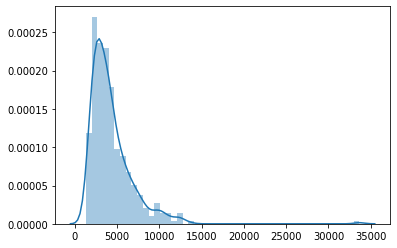

In [78]:
sns.distplot(X)

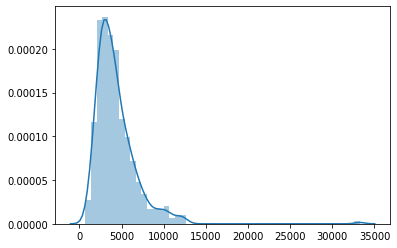

In [79]:
sns.distplot(X_adj)

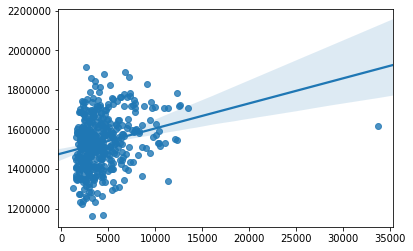

In [81]:
sns.regplot(X,confound.squeeze())

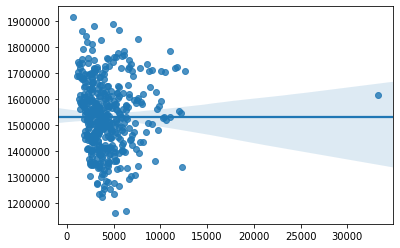

In [83]:
sns.regplot(X_adj,confound.squeeze())

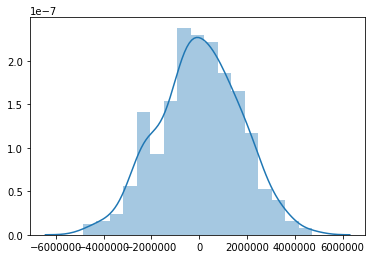

In [69]:
sns.distplot(X_adj)

In [67]:
lm.coef_

array([12.68297238])

In [66]:
X

array([[ 1681.2],
       [ 6033. ],
       [ 7117.3],
       [ 3301.5],
       [ 3608.3],
       [ 1956.6],
       [ 7280.5],
       [ 5424.9],
       [ 5526. ],
       [ 4348.1],
       [ 5184.7],
       [ 3422.2],
       [ 2607.9],
       [ 2209.1],
       [ 3798. ],
       [ 4425.8],
       [ 2396.5],
       [ 3594.9],
       [ 4060.2],
       [ 2631.8],
       [ 2471.7],
       [ 6153.8],
       [ 5795.8],
       [ 4409.6],
       [ 3976.7],
       [ 1454.4],
       [ 3736.4],
       [ 4760.2],
       [ 2165.5],
       [10002.4],
       [ 3319.6],
       [ 2042.1],
       [ 3907. ],
       [ 2166.6],
       [ 3145.6],
       [ 2311.9],
       [ 3271.6],
       [ 5492.5],
       [ 2452.6],
       [ 2988. ],
       [ 9764.7],
       [ 4085.8],
       [ 1972.8],
       [ 3613.6],
       [ 2238. ],
       [ 5062.4],
       [ 4297.1],
       [ 3425.7],
       [ 4552. ],
       [ 5517.5],
       [ 5248.1],
       [ 7823.8],
       [ 3642.8],
       [ 4423.8],
       [ 3336.3],
       [ 3

In [53]:
dir(confound)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__

In [40]:
df

,subjectkey,sex.x,interview_age.x,MRI_serial_number,smri_vol_scs_intracranialv,smri_vol_scs_ltventriclelh,smri_vol_scs_inflatventlh,smri_vol_scs_crbwmatterlh,smri_vol_scs_crbcortexlh,smri_vol_scs_tplh,smri_vol_scs_caudatelh,smri_vol_scs_putamenlh,smri_vol_scs_pallidumlh,smri_vol_scs_3rdventricle,smri_vol_scs_4thventricle,smri_vol_scs_bstem,smri_vol_scs_hpuslh,smri_vol_scs_amygdalalh,smri_vol_scs_aal,smri_vol_scs_vedclh,smri_vol_scs_ltventriclerh,smri_vol_scs_inflatventrh,smri_vol_scs_crbwmatterrh,smri_vol_scs_crbcortexrh,smri_vol_scs_tprh,smri_vol_scs_caudaterh,smri_vol_scs_putamenrh,smri_vol_scs_pallidumrh,smri_vol_scs_hpusrh,smri_vol_scs_amygdalarh,smri_vol_scs_aar,smri_vol_scs_vedcrh,smri_vol_scs_ccps,smri_vol_scs_ccmidps,smri_vol_scs_ccct,smri_vol_scs_ccmidat,smri_vol_scs_ccat
7,NDAR_INV00LJVZK2,M,121,HASH03db707f,1.601018e+06,1681.2,263.8,17034.5,52666.5,7876.5,3990.1,6261.2,1992.6,559.0,999.2,18842.8,3887.5,1668.3,525.1,3977.9,1644.4,177.9,18407.1,51786.8,7873.9,3974.5,6148.2,1996.3,4152.7,1614.0,580.4,4018.7,760.6,439.1,548.6,666.4,841.0
39,NDAR_INV030X9ZNH,F,126,HASH03db707f,1.613963e+06,6033.0,265.3,19676.6,55878.4,7795.2,4593.8,5672.4,1702.6,769.6,2372.2,19958.3,3887.0,1904.6,535.3,3903.4,5722.0,239.0,19979.5,56991.0,7664.9,4660.4,5549.4,1350.7,4057.4,1995.2,557.1,4052.9,984.0,483.1,482.4,496.4,905.1
50,NDAR_INV04CLBZAD,M,112,HASH03db707f,1.652845e+06,7117.3,466.6,19050.5,58611.1,7998.5,4496.7,6700.4,1994.0,595.7,1481.9,20642.2,4393.1,1802.9,670.1,4094.4,4472.7,92.8,18236.2,59081.9,7565.9,4711.7,6552.5,1677.5,4434.7,1685.6,885.9,4467.2,862.1,551.8,453.5,562.6,932.5
53,NDAR_INV04JY6730,F,110,HASH03db707f,1.160291e+06,3301.5,115.5,13752.7,44639.6,5735.1,3140.1,4753.5,1548.4,463.1,1175.0,15548.5,2958.1,1086.5,345.0,2896.0,3853.5,113.0,14875.3,44572.8,5608.7,3239.1,4580.5,1443.1,2898.3,993.0,527.5,3032.8,887.2,490.5,694.4,888.9,776.4
68,NDAR_INV06A9DLE9,M,131,HASH03db707f,1.571581e+06,3608.3,355.4,20969.4,63315.7,8400.3,4582.2,6127.0,2084.1,854.7,1037.8,22222.4,4460.9,1920.3,645.3,4543.6,2287.0,129.6,21234.1,63314.5,8099.8,4596.4,5896.7,1717.9,4206.4,2179.3,732.6,4248.5,784.9,437.6,495.8,415.4,650.3
97,NDAR_INV08J0E48V,F,126,HASH03db707f,1.400195e+06,1956.6,179.1,16988.7,55915.7,7652.9,3301.9,5708.4,1803.6,689.4,1535.5,19096.6,3749.2,1710.4,487.1,3702.1,2150.7,83.6,18026.9,56063.9,7417.6,3682.3,4973.1,1511.9,3920.3,1477.0,472.1,3771.6,735.3,387.1,395.4,545.9,721.1
98,NDAR_INV08K0R9C4,M,127,HASH03db707f,1.768954e+06,7280.5,292.9,20413.3,60634.2,9487.2,4876.5,6552.4,1951.8,1071.3,3186.2,22024.8,4666.1,1778.8,682.8,4716.9,6635.0,225.9,19368.2,62096.2,8608.1,5249.1,6161.7,1692.6,4870.9,1852.2,741.5,4715.9,781.5,244.8,386.6,352.4,686.8
141,NDAR_INV0C1ED337,F,125,HASH03db707f,1.293236e+06,5424.9,232.1,13189.9,40714.8,6525.7,3318.1,4390.0,1533.3,800.0,1913.8,16418.8,3594.0,1191.4,375.3,3244.9,4806.4,113.2,14394.9,40253.3,5800.4,3538.6,4317.0,1304.9,3572.4,1456.4,436.7,3579.0,658.1,236.9,314.3,354.0,679.5
144,NDAR_INV0C7TZ6YW,M,109,HASH03db707f,1.729593e+06,5526.0,244.4,18827.0,57219.9,8267.9,4071.6,5538.6,2417.6,981.6,2317.4,18527.3,4726.7,1612.6,658.6,4210.3,6065.1,172.7,19259.4,57445.9,7874.7,4444.0,5891.1,1541.1,4228.8,1793.0,696.6,4007.1,719.9,362.2,366.4,358.2,787.7
152,NDAR_INV0CKA3YZX,M,124,HASH03db707f,1.544707e+06,4348.1,343.7,16314.1,50290.5,6891.7,3952.2,5175.9,1573.2,968.9,2114.5,14978.7,4180.9,1441.9,433.7,3656.6,3943.9,332.8,15251.6,51056.9,6492.6,3883.6,4932.9,1160.5,4523.7,1746.3,560.2,3760.3,543.9,189.4,399.5,408.7,629.6


In [6]:
for cc in dat.columns:
    #if 'smri_thick' in cc:
    print(cc)

subjectkey
collection_id.x
abcd_smrip101_id
dataset_id.x
src_subject_id.x
interview_date.x
interview_age.x
sex.x
eventname.x
smri_visitid
smri_thick_cdk_banksstslh
smri_thick_cdk_cdacatelh
smri_thick_cdk_cdmdfrlh
smri_thick_cdk_cuneuslh
smri_thick_cdk_ehinallh
smri_thick_cdk_fusiformlh
smri_thick_cdk_ifpllh
smri_thick_cdk_iftmlh
smri_thick_cdk_ihcatelh
smri_thick_cdk_locclh
smri_thick_cdk_lobfrlh
smri_thick_cdk_linguallh
smri_thick_cdk_mobfrlh
smri_thick_cdk_mdtmlh
smri_thick_cdk_parahpallh
smri_thick_cdk_paracnlh
smri_thick_cdk_parsopclh
smri_thick_cdk_parsobislh
smri_thick_cdk_parstgrislh
smri_thick_cdk_pericclh
smri_thick_cdk_postcnlh
smri_thick_cdk_ptcatelh
smri_thick_cdk_precnlh
smri_thick_cdk_pclh
smri_thick_cdk_rracatelh
smri_thick_cdk_rrmdfrlh
smri_thick_cdk_sufrlh
smri_thick_cdk_supllh
smri_thick_cdk_sutmlh
smri_thick_cdk_smlh
smri_thick_cdk_frpolelh
smri_thick_cdk_tmpolelh
smri_thick_cdk_trvtmlh
smri_thick_cdk_insulalh
smri_thick_cdk_banksstsrh
smri_thick_cdk_cdacaterh
smri_t

smri_t1wcnt_cdk_pcrh
smri_t1wcnt_cdk_rracaterh
smri_t1wcnt_cdk_rrmdfrrh
smri_t1wcnt_cdk_sufrrh
smri_t1wcnt_cdk_suplrh
smri_t1wcnt_cdk_sutmrh
smri_t1wcnt_cdk_smrh
smri_t1wcnt_cdk_frpolerh
smri_t1wcnt_cdk_tmpolerh
smri_t1wcnt_cdk_trvtmrh
smri_t1wcnt_cdk_insularh
smri_t1wcnt_cf2_frlh
smri_t1wcnt_cf2_ptlh
smri_t1wcnt_cf4_frlh
smri_t1wcnt_cf4_occlh
smri_t1wcnt_cf4_tmlh
smri_t1wcnt_cf4_pllh
smri_t1wcnt_cf12_cnlh
smri_t1wcnt_cf12_occlh
smri_t1wcnt_cf12_ptoltmlh
smri_t1wcnt_cf12_supllh
smri_t1wcnt_cf12_obfrlh
smri_t1wcnt_cf12_sutmlh
smri_t1wcnt_cf12_ifpllh
smri_t1wcnt_cf12_dmfrlh
smri_t1wcnt_cf12_aomtmlh
smri_t1wcnt_cf12_pclh
smri_t1wcnt_cf12_dlprefrlh
smri_t1wcnt_cf12_parsopclh
smri_t1wcnt_cf2_frrh
smri_t1wcnt_cf2_ptrh
smri_t1wcnt_cf4_frrh
smri_t1wcnt_cf4_occrh
smri_t1wcnt_cf4_tmrh
smri_t1wcnt_cf4_plrh
smri_t1wcnt_cf12_cnrh
smri_t1wcnt_cf12_occrh
smri_t1wcnt_cf12_ptoltmrh
smri_t1wcnt_cf12_suplrh
smri_t1wcnt_cf12_obfrrh
smri_t1wcnt_cf12_sutmrh
smri_t1wcnt_cf12_ifplrh
smri_t1wcnt_cf12_dmfrrh
sm